In [55]:
% pylab inline
import pandas as pd
import numpy as np 
import pickle
import csv
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.mpl_style = 'default'
import dateutil

from sklearn import preprocessing as pp
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import svm
from sklearn.svm import LinearSVC

from sklearn import neighbors

from sklearn import grid_search
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from operator import itemgetter
from __future__ import print_function
from sklearn.grid_search import GridSearchCV

import math
from scipy import interp










Populating the interactive namespace from numpy and matplotlib


#Load Data

In [2]:
## Load the train values and labels
with open('../data/train_v&l.csv', 'r') as f:
    train_vales_and_labels = pd.read_csv(f)

# Select Features
### Select categorical features to use

In [28]:
categorical_features =['funder',
                       'installer', 
                       'basin', 
                       'subvillage',
                        'region', 
                       'region_code', 
                       'district_code', 
                       'lga', 
                       'ward',
                        'public_meeting', 
                       'scheme_management',
                        'scheme_name', 
                       'permit',
                        'extraction_type', 
                       'extraction_type_group',
                    'extraction_type_class', 
                       'management', 
                       'management_group',
                    'payment', 
                       'payment_type', 
                       'water_quality', 
                       'quality_group',
                    'quantity', 
                       'quantity_group', 
                       'source', 
                       'source_type',
                    'source_class', 
                       'waterpoint_type', 
                       'waterpoint_type_group']

### Measure cardenality of categorical features
This will be important when we use one hot encoding later on. 

In [4]:
## List the categorical features and the number of unique values each contains
for feature in categorical_features:
    values = len(pd.unique(train_vales_and_labels[feature].values.ravel()))
    print '{}: {}'.format(feature,values)



funder: 1898
installer: 2146
basin: 9
subvillage: 19288
region: 21
region_code: 27
district_code: 20
lga: 125
ward: 2092
public_meeting: 3
scheme_management: 13
scheme_name: 2697
permit: 3
extraction_type: 18
extraction_type_group: 13
extraction_type_class: 7
management: 12
management_group: 5
payment: 7
payment_type: 7
water_quality: 8
quality_group: 6
quantity: 5
quantity_group: 5
source: 10
source_type: 7
source_class: 3
waterpoint_type: 7
waterpoint_type_group: 6


### Select continuous features to use

In [29]:
continuous_features = ['amount_tsh', 'gps_height', 'days_recorded', 'latitude', 
                            'longitude', 'population', 'construction_year' ]


In [30]:
def process_train(train_vales_and_labels, categorical_features, continuous_features, test_size=.25, remove_needs_repair=False):
    """
    Function to take df of training values and test labels and preprocess them using label encoder, using
    specified features, and removing 'functional needs repair' status group if specified.
    
    Args:
        train_values_and_labels (dataframe): A df of all the values and labels of the sample
        categorical_features (list): A list of strings of all the categorical features to use in the model
        continuous_features (list): A list of strings of all the continuous features to use in the model
        n_test_size (float): The proportion of the sample to be used as the test. 
        remove_needs_repair (boolean): Specify whether or not to remove the 'functional needs repair' 
        status group. If set to True, removes from X_train and y_train all the 'functional needs repair' values.
        
    Returns: 
        X_train (dataframe): A dataframe of the values of the train in the test-train-split
        X_test (dataframe): A dataframe of the values of the test in the test-train-split
        y_train (dataframe): A dataframe of the labels of the train in the test-train-split
        y_test(dataframe): A dataframe of the labels of the test in the test-train-split     
    """
    
    ## Make a feature for the day of the month the values was recorded
    train_vales_and_labels['days_recorded'] = train_vales_and_labels['date_recorded'].apply(lambda x: (dateutil.parser.parse(x).day))
    ## Make a feature for the month of the year the value was recorded                                                           dateutil.parser.parse('2014-1-1')).days)
    train_vales_and_labels['month_recorded'] = train_vales_and_labels['date_recorded'].apply(lambda x: dateutil.parser.parse(x).month)
    

    ## Make a df of status groups 
    y = train_vales_and_labels.status_group
    le = pp.LabelEncoder()
    le.fit(y)
    y = le.transform(y)
    
    ## Make train df out of categorical features and encode them, then append
    ## continious features.
    if len(categorical_features) > 0:
        X = train_vales_and_labels[categorical_features]
        X = X.apply(pp.LabelEncoder().fit_transform)
        for feature in continuous_features:
            X[feature] = train_vales_and_labels[feature]
    else:
        X = train_vales_and_labels[continuous_features]

    
    ## Make a train split of 75% and a test of 25%
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    ## If specified, remove all values with 'needs repair' labels
    if remove_needs_repair == True:
        train_full = X_train
        train_full['status_group'] = y_train
        X_train_no_needs_repair = train_full[train_full.status_group != 1]
        y_train_no_needs_repair = X_train_no_needs_repair['status_group']
        del X_train_no_needs_repair['status_group']
        return X_train_no_needs_repair, y_train_no_needs_repair 
    
    return X_train, X_test, y_train, y_test
    


In [31]:
## Get a test-train-split of the train sample using only desired features, with the categorical 
## values label-encoded
X_train, X_test, y_train, y_test = process_train(train_vales_and_labels, categorical_features, continuous_features, .25, remove_needs_repair=False)

# Model with a Random Forest classifier
Since RF is a great "out of the box" model, this will give us a preliminary feel for how well we can predict pump functionality

In [32]:
classifier = RandomForestClassifier(n_estimators = 100, max_depth=20, n_jobs=4 )
model_fit = classifier.fit(X_train, y_train)
accuracy = accuracy_score(y_test, model_fit.predict(X_test))
print accuracy
print classification_report(y_test, model_fit.predict(X_test))



0.814882154882
             precision    recall  f1-score   support

          0       0.80      0.92      0.85      8054
          1       0.62      0.29      0.40      1080
          2       0.86      0.77      0.81      5716

avg / total       0.81      0.81      0.81     14850



# Model using only location
In a real world scenario, it would be crucial to know the degree to which pump functionality is predicated on pumps nearby. 


In [7]:
## Remove instances where there is no true location
train_no_long_0 = train_vales_and_labels[train_vales_and_labels.longitude != 0]

In [8]:
## Use only long and lat as features 
empty_categorical_features = []
long_and_lat = ['longitude', 'latitude']

In [9]:
## Make test-train split split
X_train_location, X_test_location, y_train_location, y_test_location = process_train(train_no_long_0, empty_categorical_features, long_and_lat, 0.25, remove_needs_repair=False)

/Users/David/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/David/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Implement K Nearest Neighbors Model on Longitude and Latitude
This will tell us how well we can predict water pump functionality based on the pumps' nearest neighbors

In [10]:
## Run K Nearest Neighbors on test-train split
classifier = neighbors.KNeighborsClassifier(n_neighbors=3)
model_fit = classifier.fit(X_train_location, y_train_location)
accuracy = accuracy_score(y_test_location, model_fit.predict(X_test_location))
print accuracy
print classification_report(y_test_location, model_fit.predict(X_test_location))






0.681947627978
             precision    recall  f1-score   support

          0       0.72      0.77      0.74      7952
          1       0.42      0.27      0.33       953
          2       0.66      0.62      0.64      5492

avg / total       0.67      0.68      0.68     14397



### Plot Predictions on Physical Map of Tanzania using KNN Decision Boundary

Below we plot the decision boundary of  a K-Nearest Neighbors model on a sample of the data.
We use only the longitude and latitude as features, and by doing so are plotting a physical map of the pumps in  Tanzania.



/Users/David/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


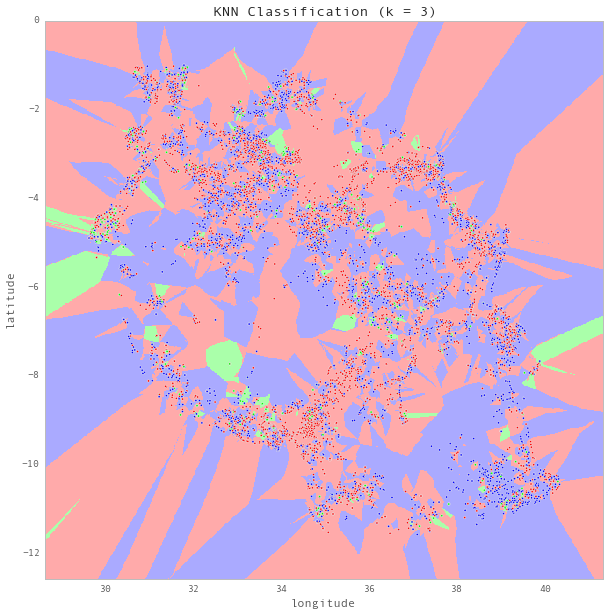

In [11]:
## Determine how many neighbors to base prediction on
n_neighbors = 3

## Assign data to variables
X = X_test_location
y = y_test_location

h = .02  # step size in the mesh

## Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

## Create an instance of Neighbours Classifier and fit the data.
clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
model_fit = clf.fit(X, y)
clf.fit(X, y)

## Plot the decision boundary. Assign a color to each
## point in the mesh [x_min, m_max]x[y_min, y_max].
x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

## Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10,10))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


## Plot also the training points
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=5, cmap=cmap_bold)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("KNN Classification (k = %i)"
          % (n_neighbors))

## Save fig to pdf
savefig('../graphs/knn_decision_boundary.pdf', bbox_inches='tight')



## Show the fig
plt.show()

### Make a Radius Neighbors Classifier on Physical Proximity 
Alternatively, physical proximity, rather than closeset neighbors may be the best way to predict functionality. We can use the longitude and latitude as features in a Radius Neighbors model. If we define the distance metric as miles between points, then the model will use all the pumps within n-mile radius to make predictions. 

In [17]:
def distance_on_unit_sphere(lat1, long1, lat2, long2):
 
    # Convert latitude and longitude to 
    # spherical coordinates in radians.
    degrees_to_radians = math.pi/180.0
         
    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians
         
    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians
         
    # Compute spherical distance from spherical coordinates.
         
    # For two locations in spherical coordinates 
    # (1, theta, phi) and (1, theta', phi')
    # cosine( arc length ) = 
    #    sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length
     
    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) + 
           math.cos(phi1)*math.cos(phi2))
    arc = math.acos( cos )
 
    # Remember to multiply arc by the radius of the earth 
    # in your favorite set of units to get length.
    arc = float(arc * 3960)
    return arc
    

In [18]:
def get_miles_distance(row1, row2):
    """
    Function to take any 2 rows where the first column is latitude and the second is longitude and call a
    function on them that finds the distance in miles between the location points of the 2 rows.
    
    Args:
        row1 (numpy array): A row of a sample that has latitude as the first column, and longitude 
        as the second.
        row2 (numpy array): A row of a sample that has latitude as the first column, and longitude 
        as the second.
    Returns:
        distance (float): The distance in miles between the 2 points. 
        
    """
    
    ## Get point of each row using their long and lat
    row1_lat = float(row1[0])
    row1_long = float(row1[1])
    row2_lat = float(row2[0])
    row2_long = float(row2[1])
    
    ## Find the distance between the 2 points
    distance = distance_on_unit_sphere(row1_lat, row1_long, row2_lat, row2_long)
    return distance


In [21]:
## Run Radius Neighbors Classifier using a distance function that gets the distance in miles between any 
## 2 points. The radius is thus defined in miles. 
classifier = neighbors.RadiusNeighborsClassifier(radius=4, metric='pyfunc', func=get_miles_distance, outlier_label=0)
model_fit_kn = classifier.fit(X_train_location, y_train_location)
accuracy = accuracy_score(y_test_location, model_fit_kn.predict(X_test_location))
print accuracy
print classification_report(y_test_location, model_fit_kn.predict(X_test_location))

0.656178370494
             precision    recall  f1-score   support

          0       0.67      0.81      0.74      7952
          1       0.47      0.16      0.24       953
          2       0.64      0.51      0.57      5492

avg / total       0.64      0.66      0.64     14397



### Plot decision boundary in physical space using longitude and latitude and a Radius Neighbors Classifier Model

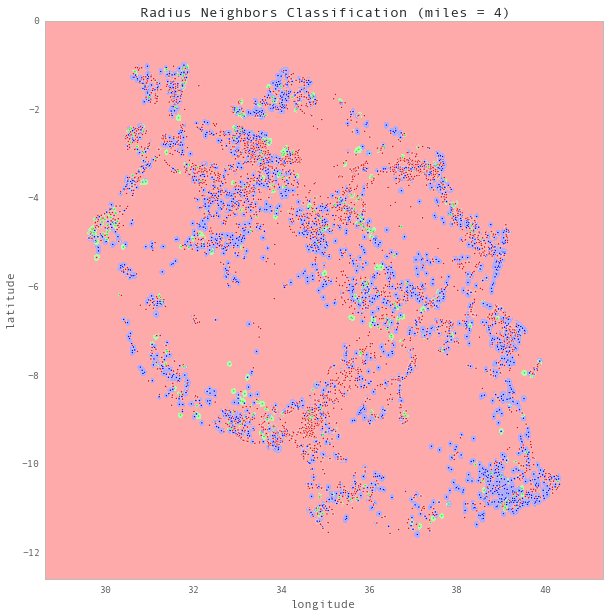

In [22]:
## Determine radius to use (in miles)
radius = 4

## Assign data to variables
X = X_test_location
y = y_test_location

h = .02  # step size in the mesh

## Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

## Create an instance of Neighbours Classifier and fit the data.
clf = neighbors.RadiusNeighborsClassifier(radius=radius, metric='pyfunc', func=get_miles_distance, outlier_label=0)

model_fit = clf.fit(X, y)
clf.fit(X, y)

## Plot the decision boundary. Assign a color to each
## point in the mesh [x_min, m_max]x[y_min, y_max].
x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

## Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10,10))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


## Plot also the training points
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=5, cmap=cmap_bold)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Radius Neighbors Classification (miles = %i)"
          % (radius))

## Save fig to pdf
savefig('../graphs/radius_neighbors_decision_boundary.pdf', bbox_inches='tight')



## Show the fig
plt.show()

## Draw ROC Curve for RF Model
An ROC curve will better allow us to see the tradeoffs we are making in our 3-way classifiction. 

In [48]:
def draw_ROC_curve(classifier, X_train, X_test, y_train, y_test):
    
    
    lb = pp.LabelBinarizer()
    lb_y_test = lb.fit_transform(y_test)
    
    # Learn to predict each class against the other
    try:
        y_score = classifier.fit(X_train, y_train).decision_function(X_test)
    except:
        y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
                    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    print y_score.shape
    for i in range(lb_y_test.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(lb_y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(lb_y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot of a ROC curve for a specific class
    plt.figure()
    plt.plot(fpr[2], tpr[2], label='Non Functional(area = %0.2f)' % roc_auc[2])
    plt.plot(fpr[1], tpr[1], label='Needs Repair (area = %0.2f)' % roc_auc[1])
    plt.plot(fpr[0], tpr[0], label='Functional (area = %0.2f)' % roc_auc[0])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()



(14850, 3)


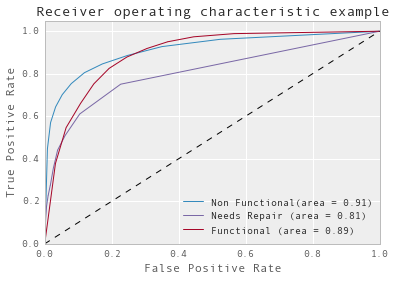

In [51]:
draw_ROC_curve(RandomForestClassifier(), X_train, X_test, y_train, y_test)

# One-hot-encode categorical variables for further modeling

In [40]:
def one_hot_process_train(train_vales_and_labels, categorical_features, continuous_features, test_size=.25, remove_needs_repair=False):
    """
    Function to take df of training values and test labels and preprocess them using label encoder, using
    specified features, and removing 'functional needs repair' status group if specified.
    
    Args:
        train_values_and_labels (dataframe): A df of all the values and labels of the sample
        categorical_features (list): A list of strings of all the categorical features to use in the model
        continuous_features (list): A list of strings of all the continuous features to use in the model
        n_test_size (float): The proportion of the sample to be used as the test. 
        remove_needs_repair (boolean): Specify whether or not to remove the 'functional needs repair' 
        status group. If set to True, removes from X_train and y_train all the 'functional needs repair' values.
        
    Returns: 
        X_train (dataframe): A dataframe of the values of the train in the test-train-split
        X_test (dataframe): A dataframe of the values of the test in the test-train-split
        y_train (dataframe): A dataframe of the labels of the train in the test-train-split
        y_test(dataframe): A dataframe of the labels of the test in the test-train-split     
    """
    
    ## Make a feature for the day of the month the values was recorded
    train_vales_and_labels['days_recorded'] = train_vales_and_labels['date_recorded'].apply(lambda x: (dateutil.parser.parse(x).day))
    ## Make a feature for the month of the year the value was recorded                                                           dateutil.parser.parse('2014-1-1')).days)
    train_vales_and_labels['month_recorded'] = train_vales_and_labels['date_recorded'].apply(lambda x: dateutil.parser.parse(x).month)
    

    ## Make a df of status groups 
    y = train_vales_and_labels.status_group
    le = pp.LabelEncoder()
    le.fit(y)
    y = le.transform(y)
    
    ## Make train df out of categorical features and encode them, then append
    ## continious features.
    if len(categorical_features) > 0:
        X = train_vales_and_labels[categorical_features]
        ohe = pp.OneHotEncoder()
        X = X.apply(pp.LabelEncoder().fit_transform)
        X = ohe.fit_transform(X).toarray()
        scaled_matrix =np.empty([X.shape[0]])
        for feature in continuous_features:
            scaled_feature = pp.scale(train_vales_and_labels[feature])
            scaled_matrix = np.column_stack((scaled_feature, scaled_matrix))
        X = np.column_stack((scaled_feature, X))
    else:
        X = train_vales_and_labels[continuous_features]
        

    
    ## Make a train split of 75% and a test of 25%
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    ## If specified, remove all values with 'needs repair' labels
    if remove_needs_repair == True:
        train_full = X_train
        train_full['status_group'] = y_train
        X_train_no_needs_repair = train_full[train_full.status_group != 1]
        y_train_no_needs_repair = X_train_no_needs_repair['status_group']
        del X_train_no_needs_repair['status_group']
        return X_train_no_needs_repair, y_train_no_needs_repair 
    
    return X_train, X_test, y_train, y_test

In [41]:
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = one_hot_process_train(train_vales_and_labels, categorical_features, continuous_features)

/Users/David/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Users/David/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Users/David/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Users/David/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


(14850, 3)


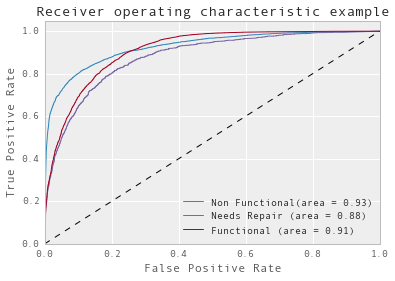

CPU times: user 16.8 s, sys: 408 ms, total: 17.2 s
Wall time: 5.35 s


In [34]:
## Draw ROC for RF without one hot encoded variables
%%time 
draw_ROC_curve(RandomForestClassifier(n_estimators = 100, max_depth=20, n_jobs=4), X_train, X_test, y_train, y_test)

(14850, 3)


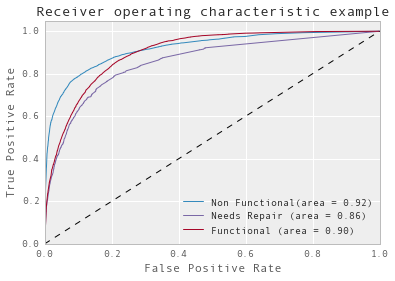

In [54]:
## Draw ROC with One Hot Encoded features
%%time
draw_ROC_curve(RandomForestClassifier(n_estimators = 100, max_depth=None, n_jobs=4), X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe)

(14850, 3)


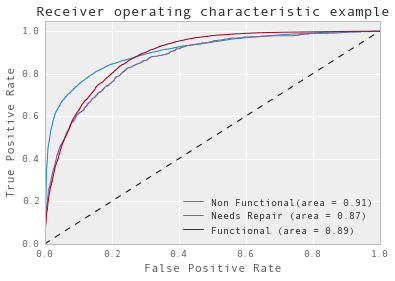

CPU times: user 16.2 s, sys: 113 ms, total: 16.3 s
Wall time: 15 s


In [32]:
## Draw ROC of Logistic Regression
%%time
draw_ROC_curve(LogisticRegression(), X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe)

# Perform Grid Search to find best perameters

In [35]:
# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

### First try the standard Random Forest Model

In [12]:
%% time


# Set the parameters by cross-validation
param_grid = [{"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
              "n_jobs": [4]}
                    ]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5,
                       scoring='%s_weighted' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()



CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 4.05 µs
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'bootstrap': False, 'min_samples_leaf': 3, 'min_samples_split': 3, 'criterion': 'entropy', 'max_features': 3, 'max_depth': None}

Grid scores on development set:

0.784 (+/-0.008) for {'bootstrap': True, 'min_samples_leaf': 1, 'min_samples_split': 1, 'criterion': 'gini', 'max_features': 1, 'max_depth': None}
0.782 (+/-0.008) for {'bootstrap': True, 'min_samples_leaf': 1, 'min_samples_split': 3, 'criterion': 'gini', 'max_features': 1, 'max_depth': None}
0.787 (+/-0.006) for {'bootstrap': True, 'min_samples_leaf': 1, 'min_samples_split': 10, 'criterion': 'gini', 'max_features': 1, 'max_depth': None}
0.785 (+/-0.005) for {'bootstrap': True, 'min_samples_leaf': 3, 'min_samples_split': 1, 'criterion': 'gini', 'max_features': 1, 'max_depth': None}
0.780 (+/-0.012) for {'bootstrap': True, 'min_samples_leaf': 3, 'min_samples_split': 3, 'criter

In [17]:
# Set the parameters by cross-validation
param_grid = [{"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [1, 3, 10],
              "max_depth": range(15,40,3),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
              "n_jobs": [4]}
                    ]
clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5,
                       scoring='%s_weighted' % score)
#clf.fit(X_train, y_train)